In [1]:
import cv2
import plot
import numpy as np
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster
import tensorflow as tf
import tamura_tf
import matplotlib.pyplot as plt
import pywt
from skimage.feature import greycomatrix, greycoprops

## Color

In [3]:
# emotional impact(pleasure arousal and dominance)


# Hue : Hue is the color portion of the color model, expressed as a number from 0 to 360 degrees:

# Saturation : Saturation is the amount of gray in the color, from 0 to 100 percent. Reducing the saturation 
# toward zero to introduce more gray produces a faded effect. Sometimes, saturation is expressed in a range from just 0-1, where 0 is gray and 1 is a primary color.

# Value (Brightness) : Value works in conjunction with saturation and describes the brightness or intensity of the color, from 0-100 percent, where 0 is completely black, 
# and 100 is the brightest and reveals the most color.

# calculate the mean and the standard deviation for both the brightness and the saturation
class Color:
    # Valdez, P., & Mehrabian, A. (1994)
    # emotional impact(pleasure arousal and dominance)
    def calculate_PDA(self,img):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        h, s ,v = cv2.split(hsv)

        # mean & standard deviation
        mean_s, std_s = np.mean(h), np.std(h)
        mean_v, std_v = np.mean(v), np.std(v)

        # Pleasure = 0.69y + 0.22s
        # Arousal : -0.31y + 0.60s
        # Dominance : -0.76y + 0.32s
        # y : the average brightness of an image
        # s : its average saturation

        Pleasure = (0.69 * mean_v) + (0.22 * mean_s)
        Arousal = (-0.31 * mean_v) + (0.60 * mean_s)
        Dominance = (-0.76 * mean_v) + (0.32 * mean_s)

        return Pleasure, Arousal, Dominance

    # Hasler, D., & Suesstrunk, S. E. (2003, June)
    def calculate_Colorfulness(self,img):
        # split the image into its respective RGB components
        (B, G, R) = cv2.split(img.astype("float"))

        # compute rg = R - G
        rg = np.absolute(R - G)

        # compute yb = 0.5 * (R + G) - B
        yb = np.absolute(0.5 * (R + G) - B)

        # compute the mean and standard deviation of both `rg` and `yb`
        (rbMean, rbStd) = (np.mean(rg), np.std(rg))
        (ybMean, ybStd) = (np.mean(yb), np.std(yb))

        # combine the mean and standard deviations
        stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
        meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))

        # derive the "colorfulness" metric and return it
        Colorfulness = stdRoot + (0.3 * meanRoot)

        return Colorfulness

    # Heckbert, P. (1982)
    def dominant_5colors(self,img):
        NUM_CLUSTERS = 5
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(150,150))     # optional, to reduce time
        ar = np.asarray(img)
        shape = ar.shape
        ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

        codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)

        vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
        counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

        value_list = []
        for i in range(NUM_CLUSTERS):
            peak = codes[i]
            colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')

            # uniform color quantification
            quantized_color = np.round(peak*(3/255))*(255/3)
            value_list.append(quantized_color)

        return np.array(value_list)
    
    # Machajdik, J., & Hanbury, A. (2010, October).
    def W3Cschool_color_percentage(self,img):
        # Color Distribution W3C
        # White, Silver, Gray, Black, Marron, Yellow, Olive, Lime, Green, Aqua, Teal, Blue, Navy, Fuchsia, Purple
        colors = {
         'black' : np.uint8([[[0,0,0]]]),
         'silver': np.uint8([[[192,192,192]]]),
         'gray': np.uint8([[[182,182,182]]]),
         'white': np.uint8([[[255,255,255]]]),
         'maroon': np.uint8([[[0,0,128]]]),
         'red': np.uint8([[[0,0,255]]]),
         'purple': np.uint8([[[128,0,128]]]),
         'fuchsia': np.uint8([[[255,0,255]]]),
         'green': np.uint8([[[0,128,0]]]),
         'lime': np.uint8([[[0,255,0]]]),
         'olive': np.uint8([[[0,128,128]]]),
         'yellow': np.uint8([[[0,255,255]]]),
         'navy': np.uint8([[[128,0,0]]]),
         'blue': np.uint8([[[255,0,0]]]),
         'teal': np.uint8([[[128,128,0]]]),
         'aqua': np.uint8([[[255,255,0]]])
        }
        color_list = []

        for color in colors.keys():
            # sensitivity is a int, typically set to 15 - 20 
            sensitivity = 15
            color_hsv = cv2.cvtColor(colors[color],cv2.COLOR_BGR2HSV)

            # HSV 이미지에서 특정 값만 추출하기 위한 임계값
            lower = np.array([color_hsv[0][0][0]-sensitivity, 0, color_hsv[0][0][2]-127])
            upper = np.array([color_hsv[0][0][0]+sensitivity, 255, color_hsv[0][0][2]+127])
            mask = cv2.inRange(img,lower,upper)
            
            # bitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.
            output = cv2.bitwise_and(img,img,mask=mask)

            ratio_color = cv2.countNonZero(mask)/(img.size/3)
            color_percentage = np.round(ratio_color*100, 2)
            #print('{0} pixel percentage: {1}'.format(color,color_percentage))
            color_list.append(color_percentage)
        return color_list

## Texture

In [13]:
class Texture:
    
    # Tamura, H., Mori, S., & Yamawaki, T. (1978).
    def calculate_Tamura(self,img_path):
        img = np.array(cv2.imread(img_path))[np.newaxis, ]
        with tf.Session() as sess:
            style_image = tf.placeholder(tf.float32, shape=img.shape, name='style_image')
            
            frcs = tamura_tf.coarseness(style_image)
            fcon = tamura_tf.contrast(style_image)
            fdir = tamura_tf.directionality(style_image)
            sess.run(tf.global_variables_initializer())
            
            coarseness = sess.run(frcs, feed_dict = {style_image:img})
            contrast = sess.run(fcon, feed_dict = {style_image:img})
            directionality = sess.run(fdir, feed_dict = {style_image:img})
        
        return coarseness,contrast, directionality

    
    # Datta, R., Joshi, D., Li, J., & Wang, J. Z. (2006, May).
    def calculate_wavelet_features(self,img):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # split_h,s,v
        h,s,v = cv2.split(hsv)

        # normalized_hsv
        h,s,v = h/180, s/255,v/255

        channels = [h,s,v]
        levels = [1,2,3]

        for channel in channels:
            coeffs = pywt.wavedecn(h, wavelet='db1',level=3)

            for level in levels:

                # numerator
                ad,da,dd = coeffs[level]['ad'], coeffs[level]['da'], coeffs[level]['dd']
                numerator = np.sum(ad) + np.sum(da) + np.sum(dd)

                # denominator
                # get det of matrix
                sign, ad_logdet = np.linalg.slogdet(ad)
                sign, da_logdet = np.linalg.slogdet(da)
                sign, dd_logdet = np.linalg.slogdet(dd)

                det_ad, det_da, det_dd = np.exp(ad_logdet), np.exp(da_logdet), np.exp(dd_logdet)

                denominator = det_ad + det_da + det_dd

                wavelet_feature = numerator / denominator

        return final_wavlet_features
    
    
    # Machajdik, J., & Hanbury, A. (2010, October).
    # Haralick, R. M., & Shapiro, L. G. (1992).
    def caculate_GLCM(self,img):
        hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        
        channels = [h,s,v]

        for channel in channels:
            glcm = greycomatrix(channel,[5],[0],256,symmetric=True,normed=True)

            contrast = greycoprops(glcm, 'contrast')[0, 0]
            correlation = greycoprops(glcm, 'correlation')[0, 0]
            energy = greycoprops(glcm, 'energy')[0, 0]
            homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
            
            GLCM_features = [contrast, correlation, energy, homogeneity]
            
        return GLCM_features

In [34]:
coeffs

[array([[0.17638889, 0.21041667, 0.26736111, ..., 2.37708333, 4.57430556,
         2.02916667],
        [0.24722222, 0.25416667, 0.25069444, ..., 1.39930556, 5.24861111,
         7.22916667],
        [0.24097222, 0.26944444, 0.25277778, ..., 5.19513889, 7.15972222,
         7.23541667],
        ...,
        [7.45486111, 7.49513889, 2.60694444, ..., 7.58472222, 7.50486111,
         7.42430556],
        [7.32430556, 7.34027778, 2.18125   , ..., 7.55972222, 7.43194444,
         7.45208333],
        [7.30625   , 7.26319444, 0.50277778, ..., 7.41111111, 7.42847222,
         7.73263889]]),
 (array([[-2.08333333e-02, -1.04166667e-02,  1.04166667e-02, ...,
           6.17361111e-01,  3.59027778e-01, -1.82916667e+00],
         [-5.55555556e-03, -6.94444444e-03, -6.94444444e-04, ...,
          -3.81250000e-01, -1.30694444e+00,  3.19444444e-02],
         [ 4.86111111e-03,  4.16666667e-03,  6.94444444e-03, ...,
          -1.77986111e+00,  5.13888889e-02, -6.25000000e-03],
         ...,
         [ 

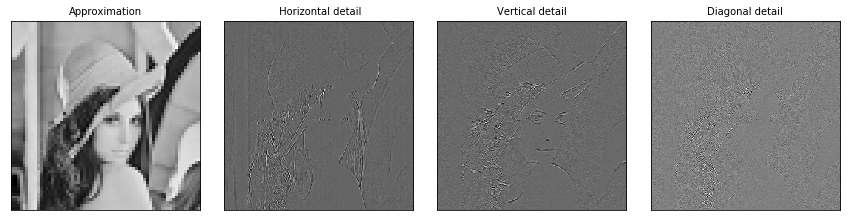

In [15]:
# wavelet
img = cv2.imread('Lena.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)


# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs = pywt.wavedecn(v, wavelet='db2', level=3)
LL, LH, HL, HH = coeffs[0], coeffs[3]['ad'], coeffs[3]['da'], coeffs[3]['dd']
fig = plt.figure(figsize=(12, 3))

for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

(512, 512, 3)


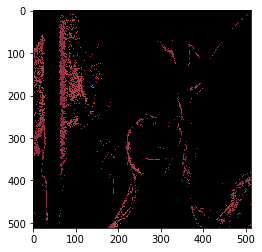

In [18]:
colors = {
 'black' : np.uint8([[[0,0,0]]]),
 'silver': np.uint8([[[192,192,192]]]),
 'gray': np.uint8([[[182,182,182]]]),
 'white': np.uint8([[[255,255,255]]]),
 'maroon': np.uint8([[[0,0,128]]]),
 'red': np.uint8([[[0,0,255]]]),
 'purple': np.uint8([[[128,0,128]]]),
 'fuchsia': np.uint8([[[255,0,255]]]),
 'green': np.uint8([[[0,128,0]]]),
 'lime': np.uint8([[[0,255,0]]]),
 'olive': np.uint8([[[0,128,128]]]),
 'yellow': np.uint8([[[0,255,255]]]),
 'navy': np.uint8([[[128,0,0]]]),
 'blue': np.uint8([[[255,0,0]]]),
 'teal': np.uint8([[[128,128,0]]]),
 'aqua': np.uint8([[[255,255,0]]])
}
    
# color percentage check
img = cv2.imread('Lena.png')
sensitivity = 15
color_hsv = cv2.cvtColor(colors['lime'],cv2.COLOR_BGR2HSV)

# HSV에서 가정할 범위를 정의함.
lower = np.array([color_hsv[0][0][0]-sensitivity, 0, color_hsv[0][0][2]-120])
upper = np.array([color_hsv[0][0][0]+sensitivity, 255, color_hsv[0][0][2]+120])

# HSV 이미지에서 특정 값만 추출하기 위한 임계값
mask = cv2.inRange(img,lower,upper)
res1 = cv2.bitwise_and(img,img,mask=mask)
plot.opencv_to_plt(res1)

In [ ]:
# Color Distribution W3C
# White, Silver, Gray, Black, Marron, Yellow, Olive, Lime, Green, Aqua, Teal, Blue, Navy, Fuchsia, Purple

# cv2.inRange() : hsv의 모든 값들을 lower_blue, upper_blue로 지정한 범위에 있는지 체크한 후, 범위에 해당하는 부분은 
# 그 값 그대로, 나머지 부분은 0으로 채워서 결과값을 반환
# twibitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.

## Organization

In [6]:
img = cv2.imread('Lena.png')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
luv

array([[[152,  89,  62],
        [152,  89,  62],
        [153,  92,  66],
        ...,
        [159,  85,  66],
        [144,  87,  60],
        [117,  90,  55]],

       [[152,  89,  62],
        [152,  89,  62],
        [153,  92,  66],
        ...,
        [159,  85,  66],
        [144,  87,  60],
        [117,  90,  55]],

       [[152,  89,  62],
        [152,  89,  62],
        [153,  92,  66],
        ...,
        [159,  85,  66],
        [144,  87,  60],
        [117,  90,  55]],

       ...,

       [[ 40, 104, 104],
        [ 40, 104, 104],
        [ 45, 101, 100],
        ...,
        [ 95,  95,  62],
        [ 90,  94,  60],
        [ 88,  96,  55]],

       [[ 40, 102, 105],
        [ 40, 102, 105],
        [ 50, 101,  99],
        ...,
        [ 93,  94,  56],
        [ 95,  94,  55],
        [ 97,  94,  53]],

       [[ 40, 102, 105],
        [ 40, 102, 105],
        [ 50, 101,  99],
        ...,
        [ 93,  94,  56],
        [ 95,  94,  55],
        [ 97,  94,  53]]